# Three-dimensional electron density reconstruction using simultaneous algebraic reconstruction tomography
## This tutorial shows how to use the code to perform tomographic reconstruction of a reconnection layer in a pulsed-power experiment


# Import Modules


In [3]:
import numpy as np
from matplotlib import pyplot as plt
import ARTv2p0 as ART # Importing ART
import importlib
importlib.reload(ART)

<module 'ARTv2p0' from 'C:\\Users\\rdatta\\Dropbox (MIT)\\PUFFIN\\Codes\\Other\\tomography\\ARTv2p0.py'>

# Synthetic Data Generation

You can upload your own 3D data, or alternatively, generate 3D synthetic data.

In this example, we use the class optimize3D to create a reconnection layer phantom using 3D gaussian functions.

In [5]:
# Generate synthetic target data

dx, dy, dz = 64, 64, 64 # Size of domain
# Generate grid
x = np.arange(0,dx); y = np.arange(0,dy); z = np.arange(0,dz)
xx, yy , zz = np.meshgrid(x,y,z) # generate 3D grid
xx, yy, zz = np.transpose(xx, (2, 0, 1)), np.transpose(yy, (2, 0, 1)), np.transpose(zz, (2, 0, 1))


# Generate the phantom with the optimize3D class
f = ART.optimize3D(xx.astype(float),yy.astype(float),zz.astype(float)) 

m = 5 # max no. of modes
A = np.zeros(m,)
mu, sig = np.zeros((m,3)), 1e9 * np.ones((m,3))

# Construct Rec. layer w/ 3D Gaussian Functions (mu contrls the position, and sig controls the spread in 3D)
# (1) Layer
A[0] = 1
mu[0,0] = dx // 2; mu[0,1] = dy // 2; mu[0,2] = dz // 2
sig[0,0] = 0.03 * dx; sig[0,1] = 0.25*dy; sig[0,2] = 10 * dz
# (2) Array flows
A[1] = 2; mu[1,0] = - 0.5 * dx; mu[1,1] = dy // 2; sig[1,0] = 0.3 * dx; sig[1,1] = 0.3 * dy
A[2] = 2; mu[2,0] =  dx + 0.5 * dx; mu[2,1] = dy // 2; sig[2,0] = 0.3 * dx; sig[2,1] = 0.3 * dy
# (3) Plasmoid
A[3] = 1
mu[3,0] = dx // 2; mu[3,1] = dy // 2 + dy // 6; mu[3,2] = dz // 2
sig[3,0] = 0.04 * dx; sig[3,1] = 0.05*dy; sig[3,2] = 10 * dz


S = f.generate3D(A,mu,sig) # 3D object to reconstruct



# Projections

Generate 2D projections form the 3D phantoms

The detctor position is controlled by the polar angle = phi and the azimuthal angle = th in spherical coordinates

Common projections are listed below:

(phi = 0 or 180, th = 0): XY projection
(phi = 90, th = 0 or 180): XZ projection
(phi = 90, th = 90 or -90): YZ projection

In [8]:
# Take projections

solver = ART.ART_3D(dx,dy,dz)

# Specify detector position in (phi,th) coordinates

angles = [(0,0),(90,0)] # (phi,th) 2 LOS
# angles = [(0,0),(90,0),(90,22.5)] # (phi,th) 3 LOS
# angles = [(0,0),(90,0),(90,22.5),(90,-22.5)] # (phi,th) 4 LOS

# Now generate weight matrices and multiply them with the 3D phantom to get projetcions
detector_size = np.max([dx,dy,dz]) # The current implementation supports square detectors of size max(dx,dy,dz)
p_targets = []
for ii in range(len(angles)):
    W =  solver.getW(phi=np.deg2rad(angles[ii][0]),th=np.deg2rad(angles[ii][1])) # xy-projection weight matrix
    p = np.reshape(W * S.flatten(),(detector_size,detector_size)) # 2D projection
    p_targets.append(p)



Generating weight matrix for phi = 0.00 degrees and th = 0.00 degrees
Generating weight matrix for phi = 90.00 degrees and th = 0.00 degrees


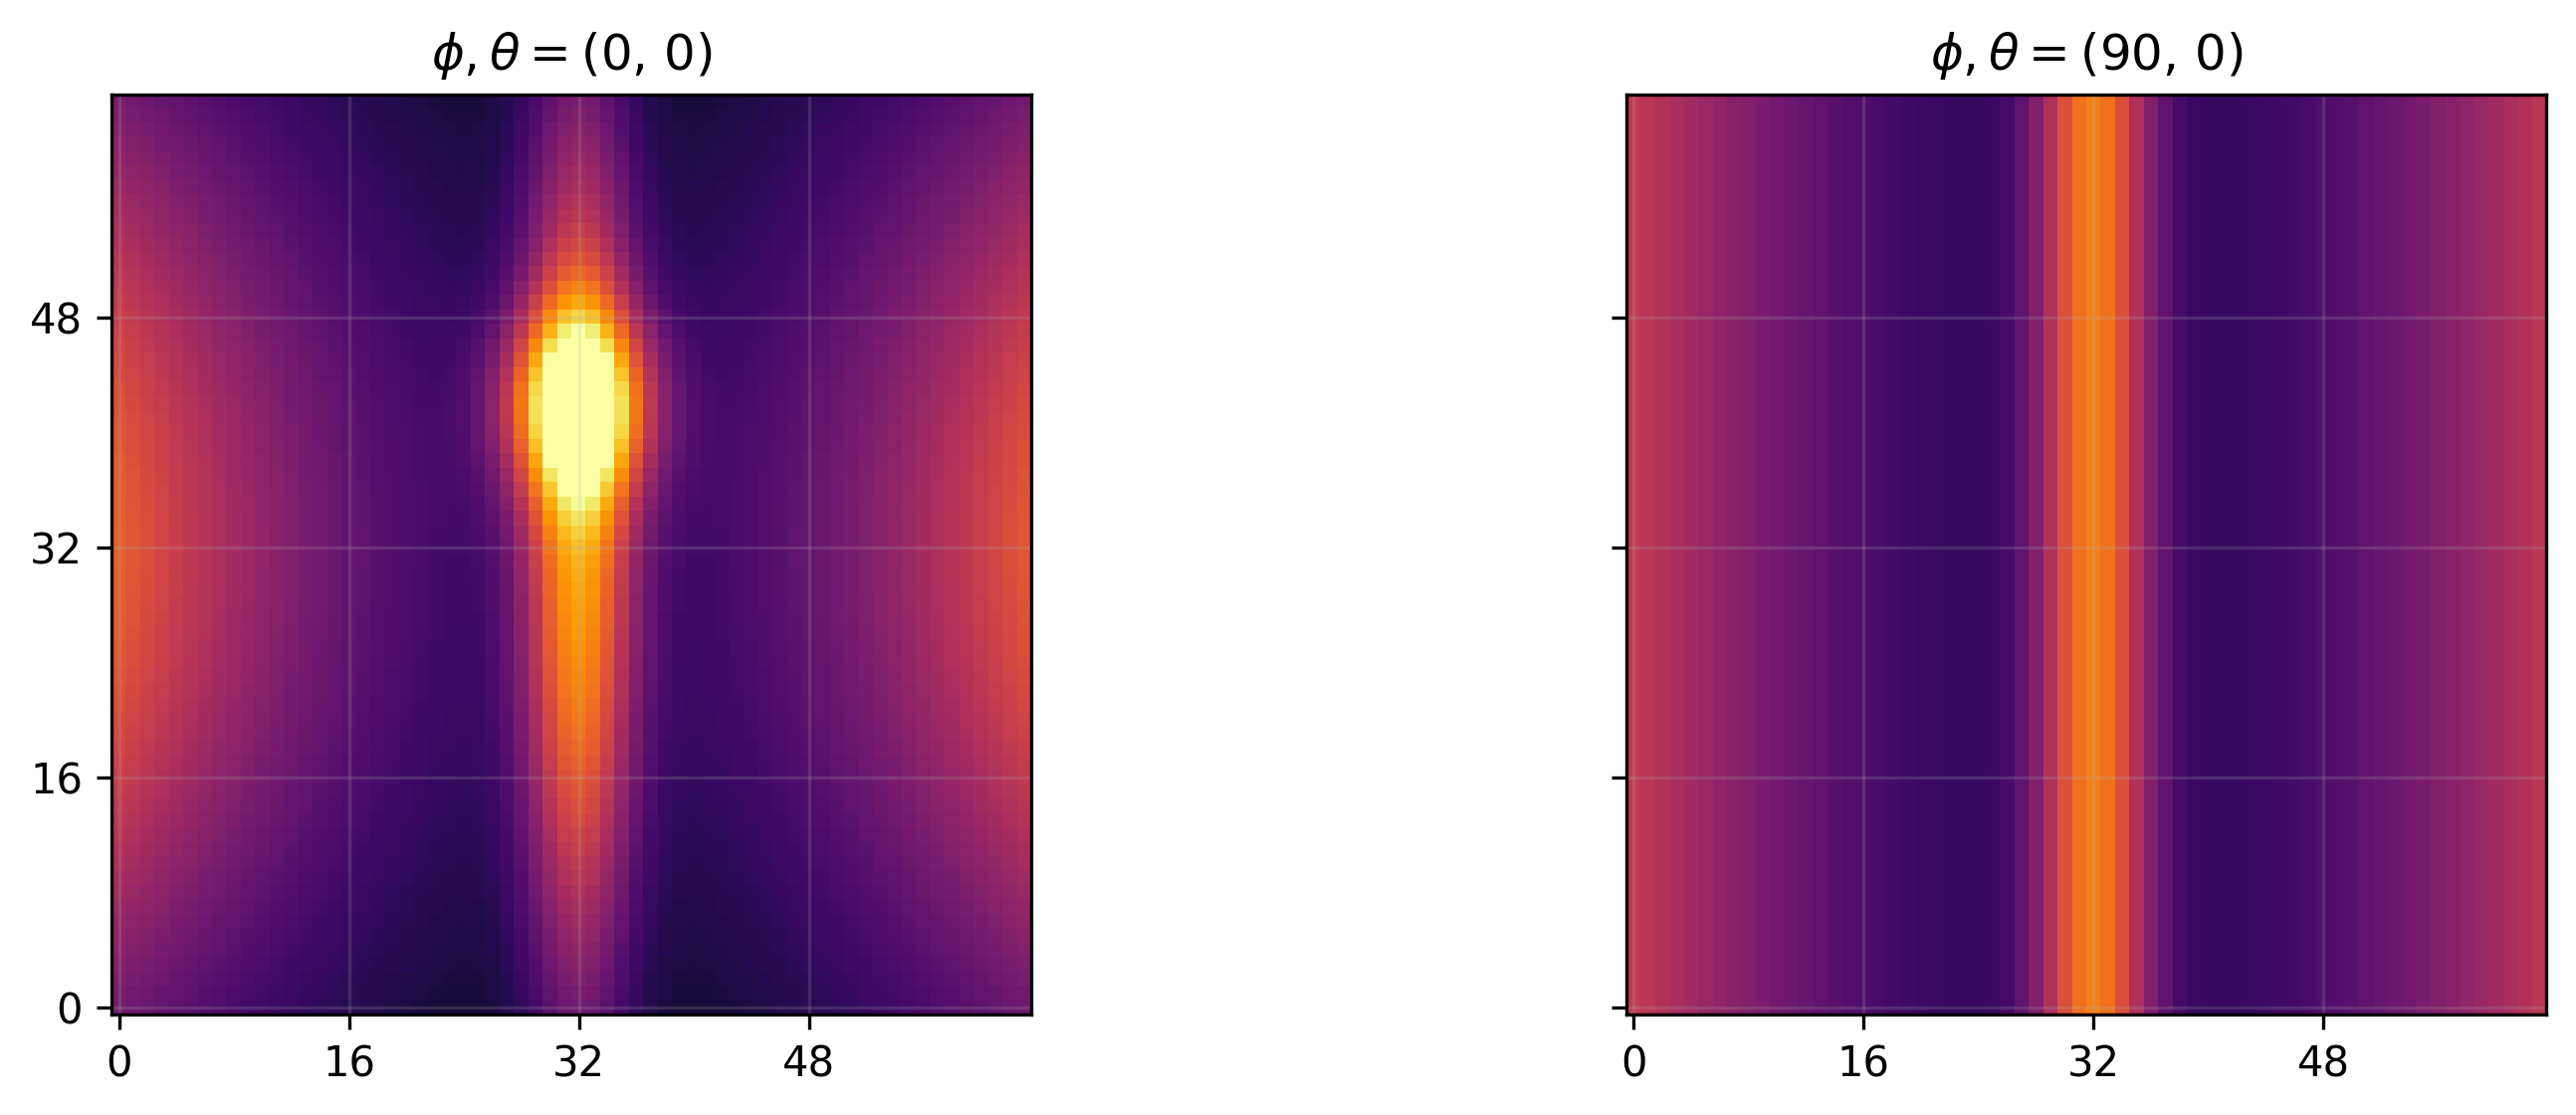

In [9]:
# Show (Target) Projections


fig, axs = plt.subplots(1,len(p_targets),dpi=300,sharey=True,sharex=True,figsize=(12,4))
for ii in range(len(p_targets)):
    axs[ii].imshow(p_targets[ii],origin='lower',vmin=0,vmax=100,cmap='inferno')
    axs[ii].grid(alpha=0.2)
    axs[ii].set_xticks(np.arange(0,dx,dx//4))
    axs[ii].set_yticks(np.arange(0,dx,dx//4))
    axs[ii].set_title('$\\phi, \\theta =$' + str(angles[ii]))






# Run Reconstruction Algorithm

In [11]:
#Run

p_out = solver.run(targets=p_targets,angles=angles,tol=1e-2,max_iter=10000)

Running 3D Art with Object Shape: (64, 64, 64)
Generating weight matrix for phi = 0.00 degrees and th = 0.00 degrees
Generating weight matrix for phi = 90.00 degrees and th = 0.00 degrees
Weight matrices generated....
D & M matrices generated....
Running....
iter   loss     
   0  0.411570
 100  0.371440
 200  0.335502
 300  0.303252
 400  0.274261
 500  0.248161
 600  0.224635
 700  0.203407
 800  0.184235
 900  0.166908
1000  0.151239
1100  0.137062
1200  0.124230
1300  0.112611
1400  0.102088
1500  0.092555
1600  0.083917
1700  0.076088
1800  0.068993
1900  0.062562
2000  0.056731
2100  0.051445
2200  0.046653
2300  0.042307
2400  0.038367
2500  0.034794
2600  0.031554
2700  0.028616
2800  0.025952
2900  0.023535
3000  0.021344
3100  0.019357
3200  0.017555
3300  0.015921
3400  0.014439
3500  0.013095
3600  0.011876
3700  0.010770
ART_3D terminated after 38.814682 s, 3777 iterations with loss = 0.010000


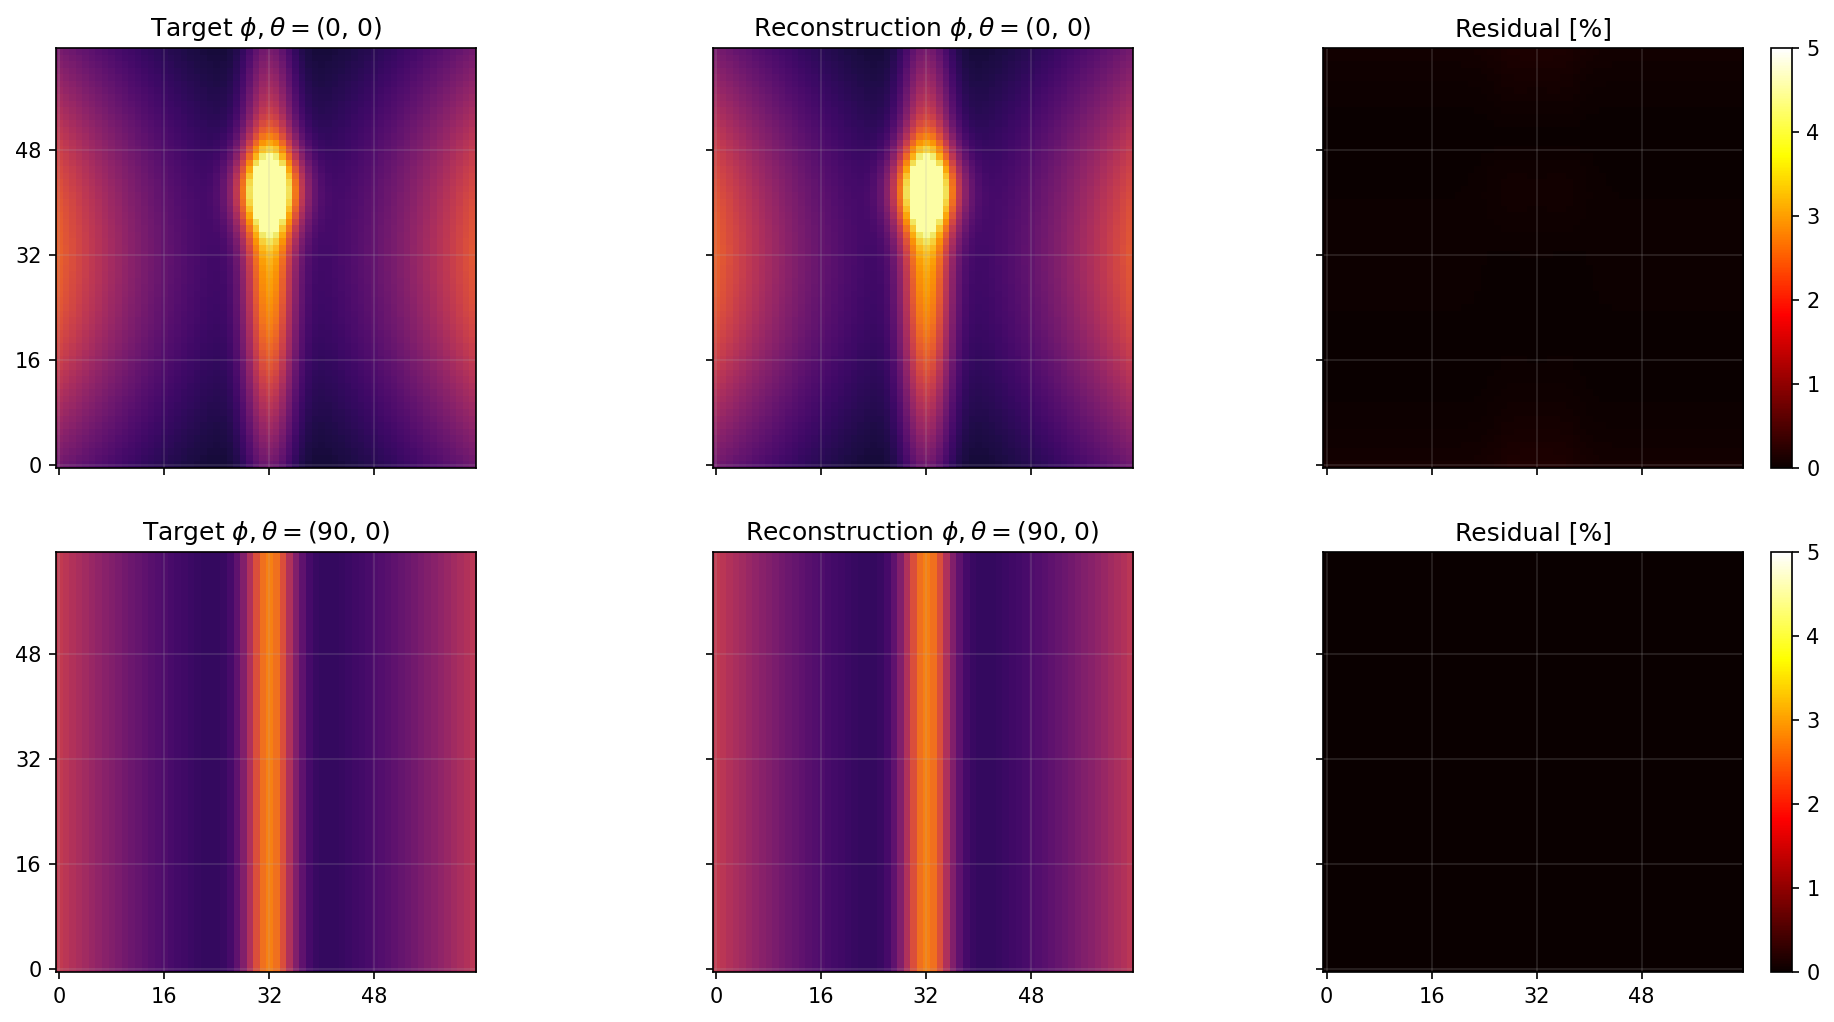

In [26]:
# Show result

fig, axs = plt.subplots(len(p_out),3,figsize=(16,8),dpi=150,sharey=True,sharex=True)

for ii in range(len(p_out)):
    axs[ii,0].imshow(p_targets[ii],cmap='inferno',origin='lower',vmin=0,vmax=100)
    axs[ii,0].set_title('Target $\\phi, \\theta =$' + str(angles[ii]))
    axs[ii,0].grid(alpha=0.2)
    axs[ii,0].set_xticks(np.arange(0,dx,dx//4))
    axs[ii,0].set_yticks(np.arange(0,dx,dx//4))


    axs[ii,1].imshow(p_out[ii],cmap='inferno',origin='lower',vmin=0,vmax=100)
    axs[ii,1].set_title('Reconstruction $\\phi, \\theta =$' + str(angles[ii]))
    axs[ii,1].grid(alpha=0.2)
    axs[ii,1].set_xticks(np.arange(0,dx,dx//4))
    axs[ii,1].set_yticks(np.arange(0,dx,dx//4))


    im = axs[ii,2].imshow(np.abs(p_out[ii]-p_targets[ii])/p_targets[ii]*100,cmap='hot',vmin=0,vmax=5,origin='lower')
    axs[ii,2].set_title('Residual [%]')
    plt.colorbar(im, ax = axs[ii,2],shrink =1)
    axs[ii,2].grid(alpha=0.2)
    axs[ii,2].set_xticks(np.arange(0,dx,dx//4))
    axs[ii,2].set_yticks(np.arange(0,dx,dx//4))



In [ ]:
# 3D Visualization - Target

import plotly.graph_objects as go


fig = go.Figure(data=go.Volume(
    x=xx.flatten(),
    y=yy.flatten(),
    z=zz.flatten(),
    value=S.flatten(),
    isomin=0.4,
    isomax=1,
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=10, # needs to be a large number for good volume rendering
    ))

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    title='(Unknown) Target')
fig.show()

In [ ]:
# 3D Visualization - Reconstruction

import plotly.graph_objects as go


fig = go.Figure(data=go.Volume(
    x=xx.flatten(), 
    y=yy.flatten(),
    z=zz.flatten(),
    value=solver.S.flatten(),
    isomin=0.4,
    isomax=1,
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=10, # needs to be a large number for good volume rendering
    ))

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
title='Reconstruction')
fig.show()

In [29]:
# Calculate 3D SSIM

# The Structural Similarity Index (SSIM) quantifies the similarity between our 3D target and the reconstruction
# https://en.wikipedia.org/wiki/Structural_similarity
# SSIM = 1 shows perfect similarity

from skimage.metrics import structural_similarity

ssim = structural_similarity(S, solver.S,
                             gaussian_weights=False,
                             data_range=solver.S.max()-solver.S.min())

print('SSIM = ', ssim)

SSIM =  0.9999998039642045
